In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = 2,
    c2 = 2,
    w = 1.4,
    w_decay = 1,
    scale_hyperparameter = False,
    regularizer = None,
    mask = True))

see one see two 2 2


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\AI-lab\\github_repo\\neural-network\\', 'dataset')
GROUP = 4
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 200
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 10
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

Checkpoint 10, Accuracy: 0.8950617283950617, Loss: 0.5579715304904513
Checkpoint 20, Accuracy: 0.8827160493827161, Loss: 0.5397920608520508
Checkpoint 30, Accuracy: 0.8888888888888888, Loss: 0.46379145869502314
Checkpoint 40, Accuracy: 0.9135802469135802, Loss: 0.43552253864429613
Checkpoint 50, Accuracy: 0.9197530864197531, Loss: 0.4283297856648763
Checkpoint 60, Accuracy: 0.9259259259259259, Loss: 0.3724005663836444
Checkpoint 70, Accuracy: 0.9135802469135802, Loss: 0.3117542973271123
Checkpoint 80, Accuracy: 0.9444444444444444, Loss: 0.2992034841466833
Checkpoint 90, Accuracy: 0.9567901234567902, Loss: 0.2396921228479456
Checkpoint 100, Accuracy: 0.9567901234567902, Loss: 0.21132257249620226
Checkpoint 110, Accuracy: 0.9382716049382716, Loss: 0.1954588183650264
Checkpoint 120, Accuracy: 0.9753086419753086, Loss: 0.1581931644015842
Checkpoint 130, Accuracy: 0.9691358024691358, Loss: 0.15838374031914604
Checkpoint 140, Accuracy: 0.9753086419753086, Loss: 0.13490123218960232
Checkpoint

In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.9656324  0.00292649 0.03144111]
[1. 0. 0.] <-> [0.9953768  0.00336199 0.00126126]
[1. 0. 0.] <-> [0.9964233  0.00247176 0.00110486]
[0. 1. 0.] <-> [0.51178396 0.47870377 0.00951227]
[1. 0. 0.] <-> [9.9595535e-01 3.1216706e-03 9.2298276e-04]
[1. 0. 0.] <-> [9.9753654e-01 1.5889772e-03 8.7449647e-04]
[1. 0. 0.] <-> [0.99028426 0.00157326 0.0081425 ]
[1. 0. 0.] <-> [0.8440443  0.14859776 0.00735792]
[0. 1. 0.] <-> [0.02423263 0.9714273  0.00434013]
[0. 1. 0.] <-> [0.00560021 0.99199945 0.00240034]
[1. 0. 0.] <-> [0.89289355 0.09939989 0.00770651]
[1. 0. 0.] <-> [0.994183   0.00154779 0.00426913]
[0. 1. 0.] <-> [0.00443255 0.9933907  0.00217681]
[0. 0. 1.] <-> [6.2170257e-03 5.3993332e-05 9.9372900e-01]
[1. 0. 0.] <-> [0.97569263 0.00240227 0.02190508]
[1. 0. 0.] <-> [0.1686863  0.82063437 0.0106793 ]
[0. 1. 0.] <-> [0.00441464 0.9934144  0.0021709 ]
[0. 0. 1.] <-> [2.2650472e-04 9.4556024e-05 9.9967897e-01]
[1. 0. 0.] <-> [0.9892614  0.00157722 0.00916149]
[1. 0. 0.] <->

In [11]:
train_acc = [h['accuracy'] for h in history]
train_mse = [h['mean_square_error'] for h in history]
train_cce = [h['categorical_crossentropy'] for h in history]

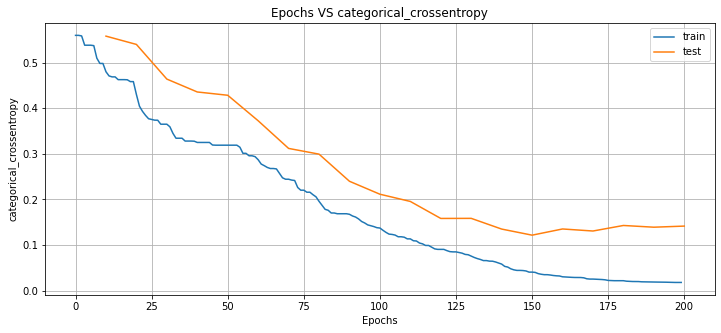

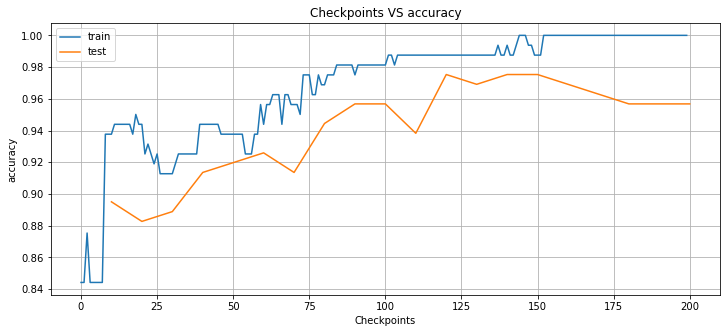

In [12]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_cce, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_acc, acc], x_label = 'Checkpoints', \
    y_label = 'accuracy', legend=['train', 'test'])

In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8950617283950617, 'mean_square_error': 0.3207345797568103, 'categorical_crossentropy': 0.5579715304904513, 'essential_metrics': {0: {'tp_hit': 72, 'fp_hit': 8, 'tn_hit': 22, 'fn_hit': 6}, 1: {'tp_hit': 9, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 7}, 2: {'tp_hit': 10, 'fp_hit': 9, 'tn_hit': 85, 'fn_hit': 4}}, 'checkpoint': 10} 


{'accuracy': 0.8827160493827161, 'mean_square_error': 0.30919888679675805, 'categorical_crossentropy': 0.5397920608520508, 'essential_metrics': {0: {'tp_hit': 74, 'fp_hit': 13, 'tn_hit': 17, 'fn_hit': 4}, 1: {'tp_hit': 11, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 5}, 2: {'tp_hit': 4, 'fp_hit': 6, 'tn_hit': 88, 'fn_hit': 10}}, 'checkpoint': 20} 


{'accuracy': 0.8888888888888888, 'mean_square_error': 0.2568958522649901, 'categorical_crossentropy': 0.46379145869502314, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 16, 'tn_hit': 14, 'fn_hit': 0}, 1: {'tp_hit': 11, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 5}, 2: {'tp_hit': 1, 'fp_hit': 2, 'tn_hit': 92, 'fn_h

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[-0.3935694  3.         1.096781  -3.        -3.       ]
 bias: 1.9847688674926758

Neuron 1: weights:
[ 2.3075995  -3.         -3.         -0.17438631 -0.2339711 ]
 bias: 2.246079444885254

Neuron 2: weights:
[-0.01888959 -3.         -0.2403582   0.57787925  3.        ]
 bias: -2.558863878250122

Neuron 3: weights:
[-2.3229742  3.         3.         3.         3.       ]
 bias: -0.35309407114982605

$
Layer 2
Neuron 0: weights:
[ 3.  3. -3. -3.]
 bias: -0.6461485028266907

Neuron 1: weights:
[ 2.5269978 -3.        -3.         3.       ]
 bias: -0.7569239139556885

Neuron 2: weights:
[-3.         0.6746765  3.         1.4993349]
 bias: 0.1446739137172699

$

